In [106]:
import numpy as np
import pandas as pd
import seaborn as sns
titanic = sns.load_dataset('titanic')

In [107]:
titanic.head()

survived  pclass     sex   age  sibsp  parch     fare embarked  class  \
0         0       3    male  22.0      1      0   7.2500        S  Third   
1         1       1  female  38.0      1      0  71.2833        C  First   
2         1       3  female  26.0      0      0   7.9250        S  Third   
3         1       1  female  35.0      1      0  53.1000        S  First   
4         0       3    male  35.0      0      0   8.0500        S  Third   

     who  adult_male deck  embark_town alive  alone  
0    man        True  NaN  Southampton    no  False  
1  woman       False    C    Cherbourg   yes  False  
2  woman       False  NaN  Southampton   yes   True  
3  woman       False    C  Southampton   yes  False  
4    man        True  NaN  Southampton    no   True

# group by 사용하기

In [108]:
titanic.groupby(['sex','class']).aggregate({'survived':[np.mean]})
# 이렇게 groupby 옆에 [] 로 다수의 col 들을 지정하면, 그 값의 구분에 따라서 aggregate 의 값을 보여주게 된다.
# 즉 groupby(row).agregate({col:funtion}) 이라고 생각하면 편하다.

survived
                   mean
sex    class           
female First   0.968085
       Second  0.921053
       Third   0.500000
male   First   0.368852
       Second  0.157407
       Third   0.135447

In [109]:
titanic.groupby(['sex']).aggregate({'survived':[np.mean,np.max]})
# 보고싶은 함수가 다수일때는 이렇게 할 수 있다.

survived     
            mean amax
sex                  
female  0.742038    1
male    0.188908    1

This immediately gives us some insight: overall, three of every four females on board survived, while only one in five males survived!

This is useful, but we might like to go one step deeper and look at survival by both sex and, say, class.
Using the vocabulary of ``GroupBy``, we might proceed using something like this:
we *group by* class and gender, *select* survival, *apply* a mean aggregate, *combine* the resulting groups, and then *unstack* the hierarchical index to reveal the hidden multidimensionality. In code:

In [110]:
titanic.groupby(['sex']).aggregate({'survived':[np.mean,np.max],'age':np.mean})
# 이렇게 aggregate 부분에 각기 다른값을 넣을 수 있다.

survived             age
            mean amax       mean
sex                             
female  0.742038    1  27.915709
male    0.188908    1  30.726645

# pivot_table 이용하기

In [111]:
titanic.pivot_table(index='sex', columns='class',aggfunc={'survived':np.mean})
# 훨씬 직관적으로 생겼다.
# titanic.groupby(['sex','class']).aggregate({'survived':np.mean}) 이 값보다 훨씬 이쁘게 나온다.
# aggfunc 는 각 element 에 보여주는 값을 정해준다.

survived                    
class      First    Second     Third
sex                                 
female  0.968085  0.921053  0.500000
male    0.368852  0.157407  0.135447

In [112]:
titanic.pivot_table(index=['sex','who'], columns='class',aggfunc={'survived':np.sum, 'fare':'mean'}) 
#이와같이 list 형태로 index와 columns 를 늘릴 수 있으며 또한 aggfunc 에 여러가지 값을 넣어 더 늘릴수도 있다.

fare                       survived             
class              First     Second      Third    First Second Third
sex    who                                                          
female child  160.962500  29.240000  19.023753        2     10    16
       woman  104.317995  20.868624  15.354351       89     60    56
male   child  117.802767  27.306022  27.716371        3      9     9
       man     65.951086  19.054124  11.340213       42      8    38

# pd.cut 으로 기준치를 만들어 countinuous 값도 pivot 에서 살펴보기

In [113]:
age = pd.cut(titanic['age'], [0, 18, 80]) 
# 기준치를 0~18/ 18~80 으로 살펴보겠다는뜻 
# 그냥 index 에 'age' 를 넣으면 conti 한 값이라 구분이 너무 많기 때문이다.

In [114]:
titanic.pivot_table(index=['sex', age], columns='class',aggfunc={'survived':np.mean})

survived                    
class               First    Second     Third
sex    age                                   
female (0, 18]   0.909091  1.000000  0.511628
       (18, 80]  0.972973  0.900000  0.423729
male   (0, 18]   0.800000  0.600000  0.215686
       (18, 80]  0.375000  0.071429  0.133663

 # pd.qcut 으로 quantile 값으로 나누기

In [115]:
fare = pd.qcut(titanic['fare'], 2) 
# qcut = 같은 quantile 을 가지게 2개로 쪼개라는뜻
titanic.pivot_table('survived',index=['sex', age],columns=[fare, 'class'])

fare            (-0.001, 14.454]                     (14.454, 512.329]  \
class                      First    Second     Third             First   
sex    age                                                               
female (0, 18]               NaN  1.000000  0.714286          0.909091   
       (18, 80]              NaN  0.880000  0.444444          0.972973   
male   (0, 18]               NaN  0.000000  0.260870          0.800000   
       (18, 80]              0.0  0.098039  0.125000          0.391304   

fare                                 
class              Second     Third  
sex    age                           
female (0, 18]   1.000000  0.318182  
       (18, 80]  0.914286  0.391304  
male   (0, 18]   0.818182  0.178571  
       (18, 80]  0.030303  0.192308

 # margin 으로 marginal sum 된 값도 살펴보기

In [116]:
titanic.pivot_table('survived', index='sex', columns='class', margins=True)
# 맨 앞에 survived 를 써놓은것은 np.mean 으로 보겠다는뜻이다.

class      First    Second     Third       All
sex                                           
female  0.968085  0.921053  0.500000  0.742038
male    0.368852  0.157407  0.135447  0.188908
All     0.629630  0.472826  0.242363  0.383838

# pivot table 로 바로 시각화해보기

In [117]:
births = pd.read_csv('C:/Users/Han/Desktop/Statistics/Python/Dataset/births.csv')

Taking a look at the data, we see that it's relatively simple–it contains the number of births grouped by date and gender:

In [118]:
births.head()

year  month  day gender  births
0  1969      1  1.0      F    4046
1  1969      1  1.0      M    4440
2  1969      1  2.0      F    4454
3  1969      1  2.0      M    4548
4  1969      1  3.0      F    4548

We can start to understand this data a bit more by using a pivot table.
Let's add a decade column, and take a look at male and female births as a function of decade:

In [119]:
births['decade'] = 10 * (births['year'] // 10)
births.pivot_table('births',index='decade', columns='gender', aggfunc='sum')

gender         F         M
decade                    
1960     1753634   1846572
1970    16263075  17121550
1980    18310351  19243452
1990    19479454  20420553
2000    18229309  19106428

We immediately see that male births outnumber female births in every decade.

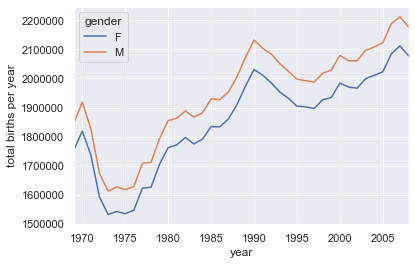

In [120]:
import matplotlib.pyplot as plt
births.pivot_table('births', index='year', columns='gender', aggfunc='sum').plot()
plt.ylabel('total births per year');